In [1]:
#error message 제거
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [2]:
IMAGE_PATH = '/home/jwjang/final_final_data'

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import pathlib

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.9.12
Tensorflow version: 2.8.0
Keras version: 2.8.0


In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.3
)

train_generator = datagen.flow_from_directory(
    IMAGE_PATH,
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    subset = 'training'
)

valid_generator = datagen.flow_from_directory(
    IMAGE_PATH,
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    subset = 'validation'
)

Found 30849 images belonging to 10 classes.
Found 13215 images belonging to 10 classes.


In [5]:
image_batch, label_batch = next(valid_generator)
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 10))

In [6]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('can_labels.txt', 'w') as f:
  f.write(labels)

{'2%_peach': 0, 'chilsung_cider': 1, 'coca_cola': 2, 'demisoda': 3, 'fanta_orange': 4, 'gatorade': 5, 'pepsi': 6, 'pocari_sweat': 7, 'powerade': 8, 'welchs_grape': 9}


In [7]:
%cat can_labels.txt

2%_peach
chilsung_cider
coca_cola
demisoda
fanta_orange
gatorade
pepsi
pocari_sweat
powerade
welchs_grape

In [8]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')
base_model.trainable = False

In [9]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  #tf.keras.layers.Dropout(0.5),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=10, activation='softmax')
])

In [10]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [11]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 4


In [12]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=10,
                    validation_data=valid_generator,
                    validation_steps=len(valid_generator))

Epoch 1/10
965/965 [==============================] - 52s 51ms/step - loss: 0.1393 - accuracy: 0.9588 - val_loss: 0.0446 - val_accuracy: 0.9852
Epoch 2/10
965/965 [==============================] - 48s 49ms/step - loss: 0.0290 - accuracy: 0.9911 - val_loss: 0.0167 - val_accuracy: 0.9949
Epoch 3/10
965/965 [==============================] - 48s 49ms/step - loss: 0.0203 - accuracy: 0.9936 - val_loss: 0.0219 - val_accuracy: 0.9937
Epoch 4/10
965/965 [==============================] - 48s 49ms/step - loss: 0.0097 - accuracy: 0.9968 - val_loss: 0.0745 - val_accuracy: 0.9802
Epoch 5/10
965/965 [==============================] - 48s 49ms/step - loss: 0.0144 - accuracy: 0.9953 - val_loss: 0.0385 - val_accuracy: 0.9904
Epoch 6/10
965/965 [==============================] - 48s 49ms/step - loss: 0.0078 - accuracy: 0.9976 - val_loss: 0.0148 - val_accuracy: 0.9958
Epoch 7/10
965/965 [==============================] - 48s 49ms/step - loss: 0.0123 - accuracy: 0.9963 - val_loss: 0.0126 - val_accuracy:

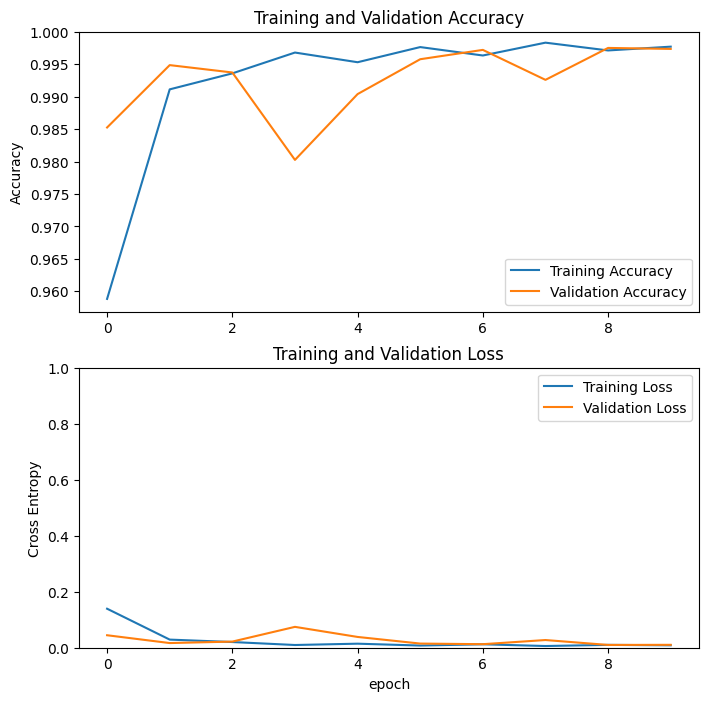

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [14]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [15]:
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 58


In [18]:
history_fine = model.fit(train_generator,
                         steps_per_epoch=len(train_generator), 
                         epochs=5,
                         validation_data=valid_generator,
                         validation_steps=len(valid_generator))

Epoch 1/5
965/965 [==============================] - 64s 64ms/step - loss: 0.1567 - accuracy: 0.9668 - val_loss: 0.0108 - val_accuracy: 0.9973
Epoch 2/5
965/965 [==============================] - 61s 63ms/step - loss: 0.0263 - accuracy: 0.9924 - val_loss: 0.0080 - val_accuracy: 0.9978
Epoch 3/5
965/965 [==============================] - 61s 63ms/step - loss: 0.0147 - accuracy: 0.9954 - val_loss: 0.0075 - val_accuracy: 0.9979
Epoch 4/5
965/965 [==============================] - 61s 63ms/step - loss: 0.0109 - accuracy: 0.9973 - val_loss: 0.0050 - val_accuracy: 0.9984
Epoch 5/5
965/965 [==============================] - 61s 63ms/step - loss: 0.0068 - accuracy: 0.9979 - val_loss: 0.0053 - val_accuracy: 0.9982


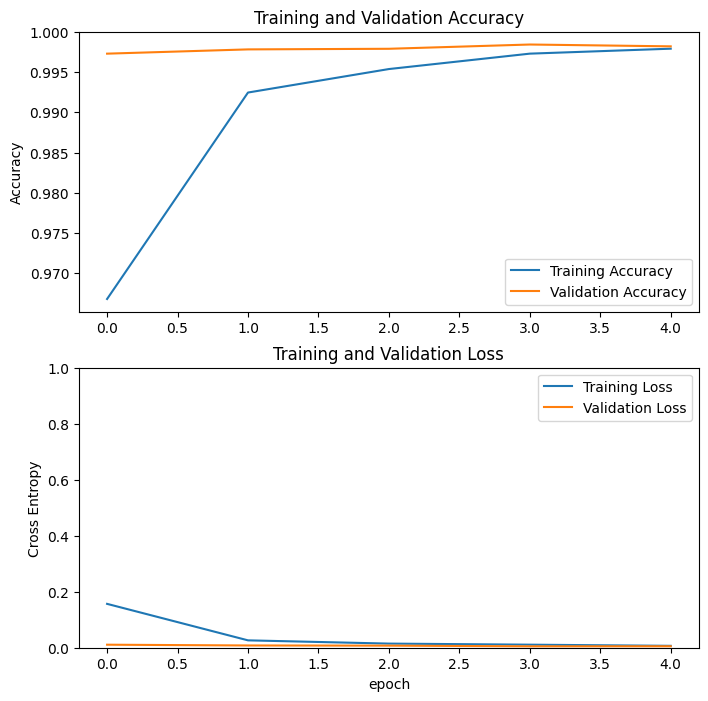

In [19]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
os.chdir("/home/jwjang/project_tf28/")

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('mobilenet_1105_1515.tflite', 'wb') as f:
  f.write(tflite_model)

2022-11-06 17:27:55.267003: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmp8ulsbwt1/assets


INFO:tensorflow:Assets written to: /tmp/tmp8ulsbwt1/assets
2022-11-06 17:28:10.142527: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-11-06 17:28:10.142565: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.


In [22]:
# # A generator that provides a representative dataset
# def representative_data_gen():
#   dataset_list = tf.data.Dataset.list_files(IMAGE_PATH + '*/*')
#   for i in range(100):
#     image = next(iter(dataset_list))
#     image = tf.io.read_file(image)
#     image = tf.io.decode_jpeg(image, channels=3)
#     image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
#     image = tf.cast(image / 255., tf.float32)
#     image = tf.expand_dims(image, 0)
#     yield [image]

# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# # This enables quantization
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# # This sets the representative dataset for quantization
# converter.representative_dataset = representative_data_gen
# # This ensures that if any ops can't be quantized, the converter throws an error
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# # For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
# converter.target_spec.supported_types = [tf.int8]
# # These set the input and output tensors to uint8 (added in r2.3)
# converter.inference_input_type = tf.uint8
# converter.inference_output_type = tf.uint8
# tflite_model = converter.convert()

# with open('mobilenet_v2_1.0_224_quant.tflite', 'wb') as f:
#   f.write(tflite_model)